# Exploración y Análisis Descriptivo (EDA)

Este cuaderno realiza un análisis descriptivo de `df_data`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Seaborn es opcional; si no está instalado, seguimos con matplotlib
try:
    import seaborn as sns
    sns.set(style='whitegrid', context='notebook')
except Exception:
    sns = None

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 11


In [2]:
# Carga opcional de datos si no existe df_data
if 'df_data' not in globals():
    DATA_PATH = '../Data/Datos.xlsx'  # <- Cambia por tu archivo
    try:
        df_data = pd.read_excel(DATA_PATH)
        print(f'Datos cargados desde: {DATA_PATH}. Shape: {df_data.shape}')
    except Exception as e:
        print('No se pudo cargar el archivo. Define df_data manualmente o ajusta DATA_PATH.')
        print('Error:', e)


Datos cargados desde: ../Data/Datos.xlsx. Shape: (7662, 35)


## Resumen general y utilidades

In [3]:
def resumen_columnas(df: pd.DataFrame) -> pd.DataFrame:
    info = []
    for col in df.columns:
        s = df[col]
        dtype = str(s.dtype)
        n = len(s)
        n_null = s.isna().sum()
        p_null = (n_null / n * 100) if n else np.nan
        n_unique = s.nunique(dropna=True)
        example_vals = None
        if s.dtype == 'object' or str(s.dtype).startswith('string') or s.dtype.name == 'category':
            top_vals = s.dropna().value_counts().head(3).index.tolist()
            example_vals = ', '.join(map(str, top_vals)) if top_vals else ''
        row = {
            'columna': col,
            'dtype': dtype,
            'no_nulos': n - n_null,
            'nulos': n_null,
            '%_nulos': round(p_null, 2),
            'unicos': int(n_unique),
            'ejemplos': example_vals or ''
        }
        if np.issubdtype(s.dropna().dtype, np.number):
            desc = s.describe(percentiles=[0.25, 0.5, 0.75])
            row.update({
                'min': desc.get('min', np.nan),
                'p25': desc.get('25%', np.nan),
                'mediana': desc.get('50%', np.nan),
                'media': desc.get('mean', np.nan),
                'p75': desc.get('75%', np.nan),
                'max': desc.get('max', np.nan)
            })
        info.append(row)
    res = pd.DataFrame(info)
    orden = ['columna','dtype','no_nulos','nulos','%_nulos','unicos','ejemplos','min','p25','mediana','media','p75','max']
    cols = [c for c in orden if c in res.columns]
    return res[cols].sort_values('%_nulos', ascending=False) if '%_nulos' in res else res

def detectar_duplicados(df: pd.DataFrame) -> int:
    return int(df.duplicated().sum())

def columnas_constantes(df: pd.DataFrame) -> list:
    return [c for c in df.columns if df[c].nunique(dropna=False) <= 1]

def outliers_iqr(df: pd.DataFrame) -> pd.DataFrame:
    nums = df.select_dtypes(include=[np.number])
    rows = []
    for col in nums.columns:
        s = nums[col].dropna()
        if s.empty:
            continue
        q1, q3 = s.quantile(0.25), s.quantile(0.75)
        iqr = q3 - q1
        low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
        n_out = int(((nums[col] < low) | (nums[col] > high)).sum())
        rows.append({'columna': col, 'outliers': n_out, '%_outliers': round(100*n_out/len(nums), 2)})
    return pd.DataFrame(rows).sort_values('%_outliers', ascending=False)

def plot_missingness(df: pd.DataFrame):
    miss = df.isna().mean().sort_values(ascending=True) * 100
    if (miss > 0).any():
        miss = miss[miss > 0]
        miss.plot(kind='barh', color='#c44e52')
        plt.title('% de valores faltantes por columna')
        plt.xlabel('% faltantes')
        plt.ylabel('columna')
        plt.show()
    else:
        print('No hay valores faltantes.')

def plot_correlaciones(df: pd.DataFrame):
    nums = df.select_dtypes(include=[np.number])
    if nums.shape[1] < 2:
        print('No hay suficientes columnas numéricas para correlación.')
        return
    corr = nums.corr(numeric_only=True)
    if sns is not None:
        ax = sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
        ax.set_title('Mapa de calor de correlaciones (numéricas)')
        plt.show()
    else:
        plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
        plt.colorbar()
        plt.title('Mapa de calor de correlaciones (numéricas)')
        plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
        plt.yticks(range(len(corr.columns)), corr.columns)
        plt.tight_layout(); plt.show()

def plot_distribuciones_numericas(df: pd.DataFrame, top_n: int = 8):
    nums = df.select_dtypes(include=[np.number])
    if nums.empty:
        print('No hay variables numéricas para graficar.')
        return
    cols = nums.var().sort_values(ascending=False).head(top_n).index.tolist()
    n = len(cols)
    ncols = 2
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4*nrows))
    axes = np.array(axes).reshape(-1)
    for i, col in enumerate(cols):
        ax = axes[i]
        if sns is not None:
            sns.histplot(df[col].dropna(), kde=True, ax=ax, color='#4c72b0')
        else:
            ax.hist(df[col].dropna(), bins=30, color='#4c72b0', alpha=0.8)
        ax.set_title(f'Distribución: {col}')
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout(); plt.show()

def plot_categoricas(df: pd.DataFrame, top_n_cols: int = 6, top_n_vals: int = 10):
    cats = df.select_dtypes(include=['object', 'category', 'string'])
    if cats.empty:
        print('No hay variables categóricas para graficar.')
        return
    # Ordenar por cardinalidad ascendente para ver primero las de menos categorías
    cols = cats.nunique(dropna=False).sort_values().head(top_n_cols).index.tolist()
    n = len(cols); ncols = 2; nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(14, 4*nrows))
    axes = np.array(axes).reshape(-1)
    for i, col in enumerate(cols):
        ax = axes[i]
        vc = df[col].astype('string').value_counts(dropna=False).head(top_n_vals)
        vc.plot(kind='bar', color='#55a868', ax=ax)
        ax.set_title(f'Top valores: {col}')
        ax.set_ylabel('frecuencia')
        ax.tick_params(axis='x', labelrotation=45)
        for lbl in ax.get_xticklabels():
            lbl.set_horizontalalignment('right')
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout(); plt.show()


## Ejecutar EDA sobre `df_data`

In [4]:
# Resumen general
print('Shape:', df_data.shape)
print('Duplicados:', detectar_duplicados(df_data))
consts = columnas_constantes(df_data)
print('Columnas constantes:', consts if consts else 'Ninguna')
res_cols = resumen_columnas(df_data)
display(res_cols.head(30))


Shape: (7662, 35)
Duplicados: 18
Columnas constantes: Ninguna


,columna,dtype,no_nulos,nulos,%_nulos,unicos,ejemplos,min,p25,mediana,media,p75,max
23,P57,float64,538,7124,92.98,5,,1.000000,2.000000,5.000000,3.814126,5.000000,5.000000e+00
19,P29,float64,4870,2792,36.44,3,,0.000000,1.000000,1.000000,1.191376,1.000000,2.000000e+00
18,P27,float64,5978,1684,21.98,13,,1.000000,1.000000,1.000000,4.668618,3.000000,9.900000e+01
21,P34,float64,6522,1140,14.88,5,,1.000000,1.000000,1.000000,1.387918,1.000000,5.000000e+00
20,P33,float64,6522,1140,14.88,6,,1.000000,1.000000,1.000000,1.805888,2.000000,6.000000e+00
2,GPSLONG,float64,6620,1042,13.60,5825,,-77.297173,-74.826292,73.115492,7.558627,75.484364,7.878275e+01
1,GPSLAT,float64,6620,1042,13.60,5839,,-77.277221,4.432272,5.675870,6.140382,7.909766,1.126948e+01
15,P9,float64,6683,979,12.78,50,,1.000000,2.000000,9.000000,62.729164,23.000000,4.321000e+03
22,P56,float64,6791,871,11.37,9,,1.000000,5.000000,9.000000,7.137240,9.000000,9.000000e+00
24,P64,float64,6804,858,11.20,9,,1.000000,9.000000,9.000000,8.059083,9.000000,9.000000e+00


In [5]:
# Estadísticos descriptivos
display(df_data.select_dtypes(include=[np.number]).describe().T)
display(df_data.select_dtypes(include=['object','category','string']).describe().T)


,count,mean,std,min,25%,50%,75%,max
AÑO,7662.0,2020.727095,2.489827,2018.000000,2018.000000,2023.000000,2023.000000,2.023000e+03
GPSLAT,6620.0,6.140382,3.417394,-77.277221,4.432272,5.675870,7.909766,1.126948e+01
GPSLONG,6620.0,7.558627,74.597830,-77.297173,-74.826292,73.115492,75.484364,7.878275e+01
SECTOR,7662.0,1993.167189,3216.746402,0.000000,13.000000,705.000000,2105.000000,9.999900e+04
SECCION,7662.0,12.033803,33.062799,0.000000,2.000000,3.000000,6.000000,9.990000e+02
MANZANA,7662.0,19.517750,117.912282,0.000000,4.000000,9.000000,17.000000,9.904000e+03
DANE5,7662.0,36881.520230,27746.655225,5001.000000,8758.000000,25843.000000,66001.000000,8.600100e+04
PB1,7662.0,1.111720,0.315042,1.000000,1.000000,1.000000,1.000000,2.000000e+00
PERSONAS,7662.0,3.521926,1.746042,1.000000,2.000000,3.000000,4.000000,1.500000e+01
EDAD,7662.0,40.037588,18.351039,12.000000,24.000000,38.000000,56.000000,7.900000e+01


,count,unique,top,freq
DIRECCION_FILTRO,7662,7500,99,22
P10,7662,5070,88,1173
P15,7662,765,03,1939
MUNICIPIO_NOMBRE,7662,72,"Bogotá, D.C.",833
Nombre Municipio,7662,72,"BOGOTÁ, D.C.",833
Nombre Departamento,7662,26,ANTIOQUIA,1103


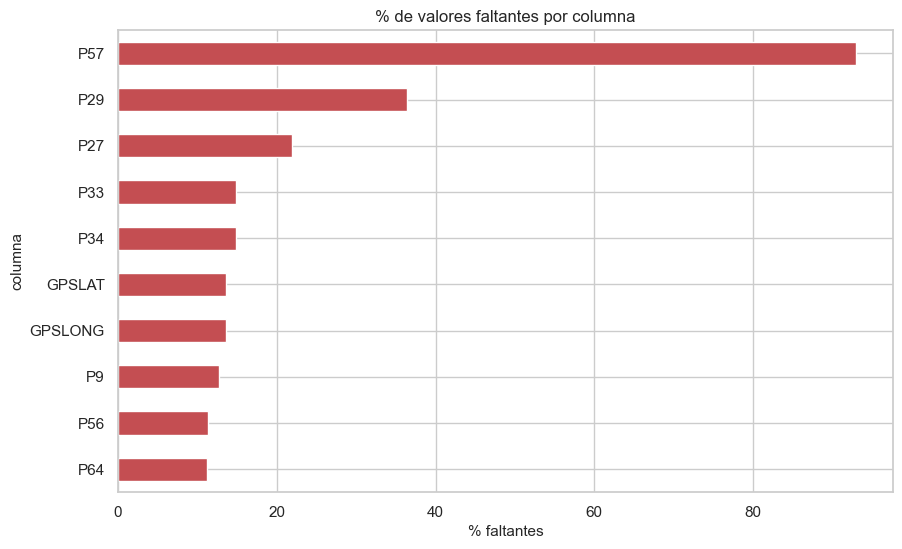

In [6]:
# Valores faltantes
plot_missingness(df_data)


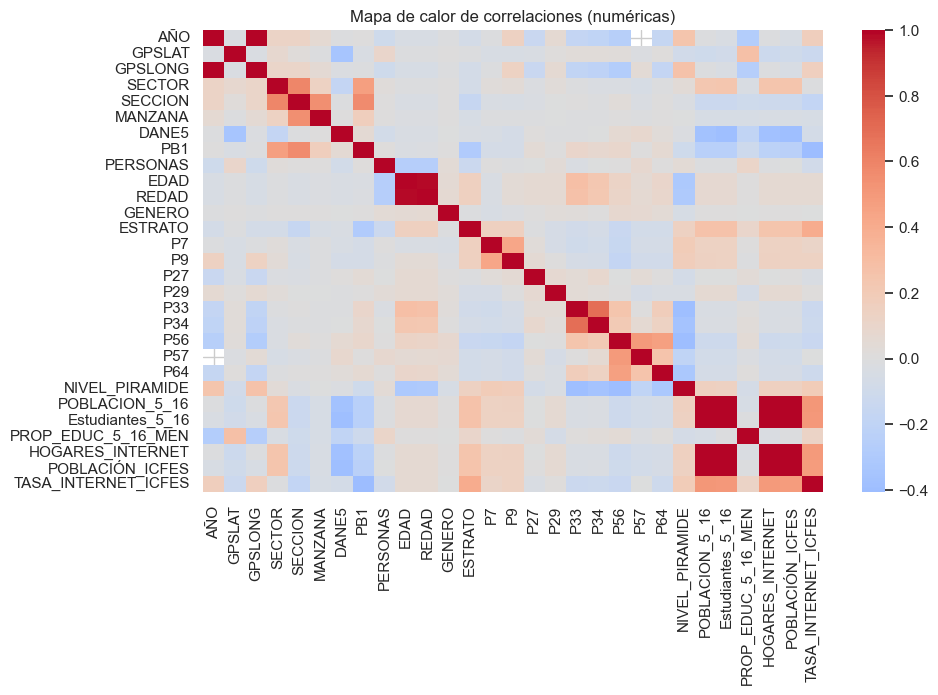

In [7]:
# Correlaciones entre variables numéricas
plot_correlaciones(df_data)


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

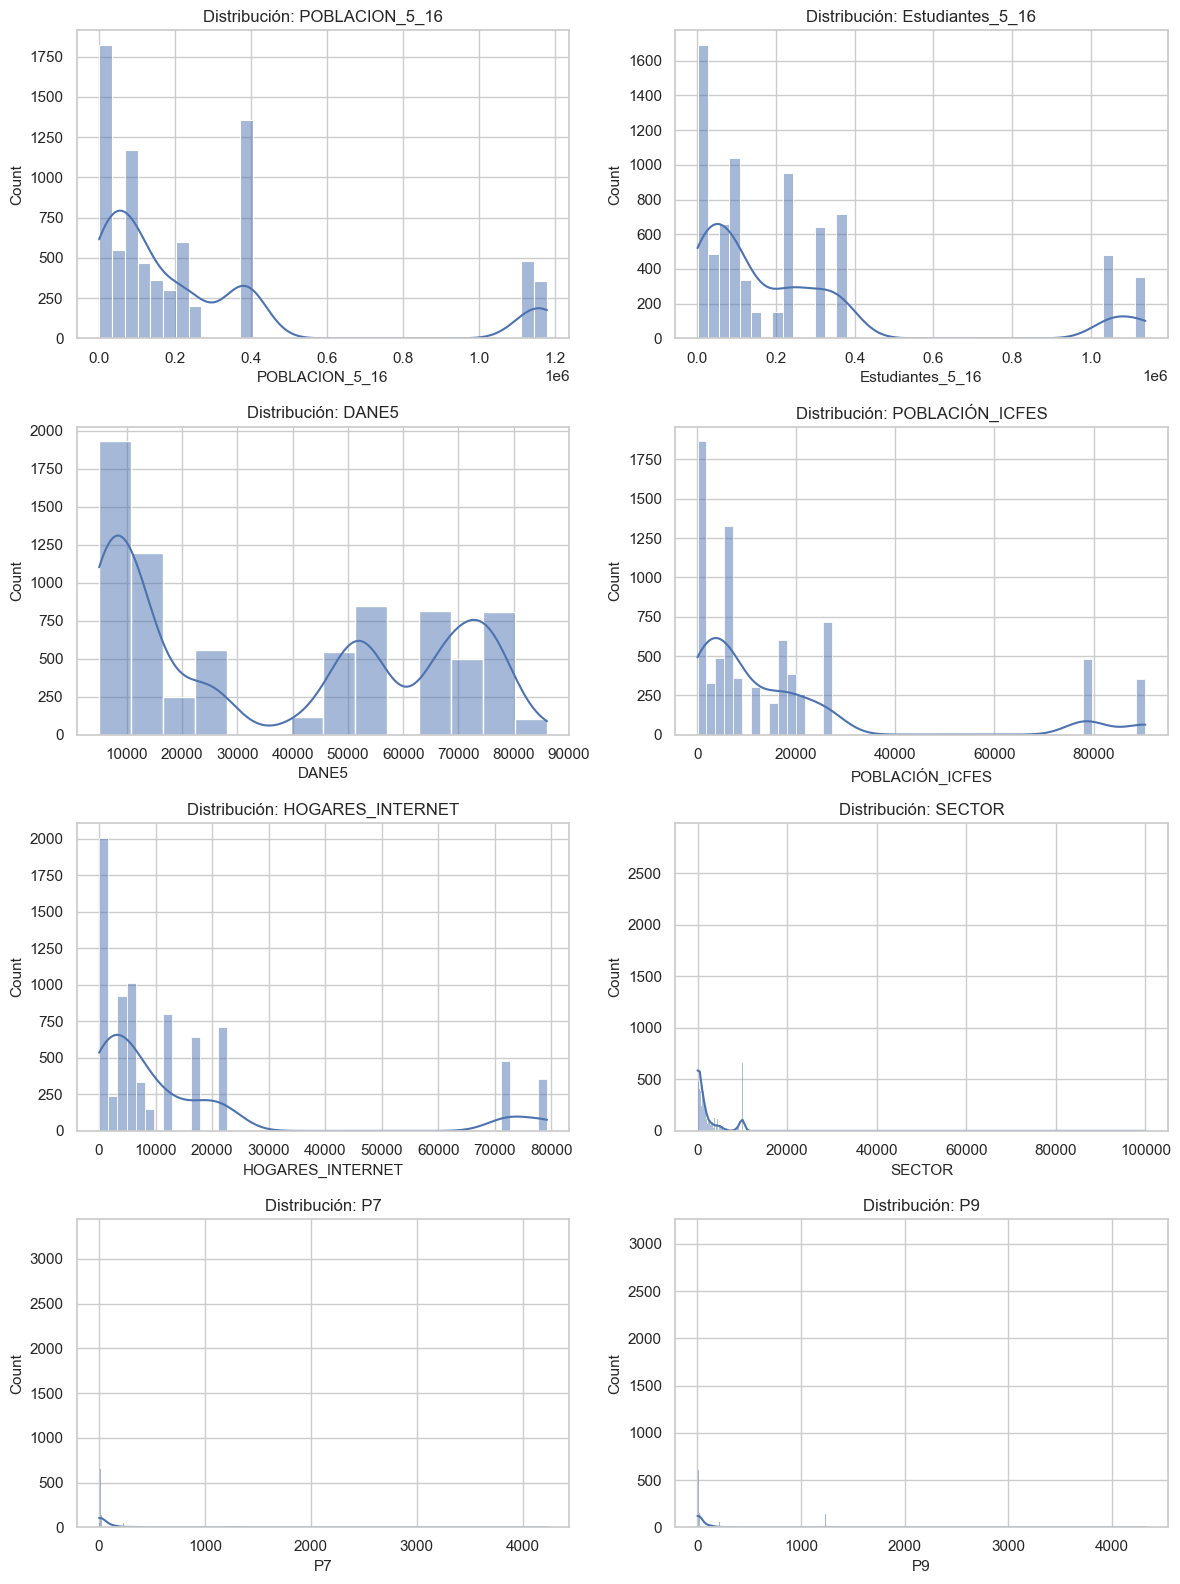

In [8]:
# Distribuciones numéricas
plot_distribuciones_numericas(df_data, top_n=8)


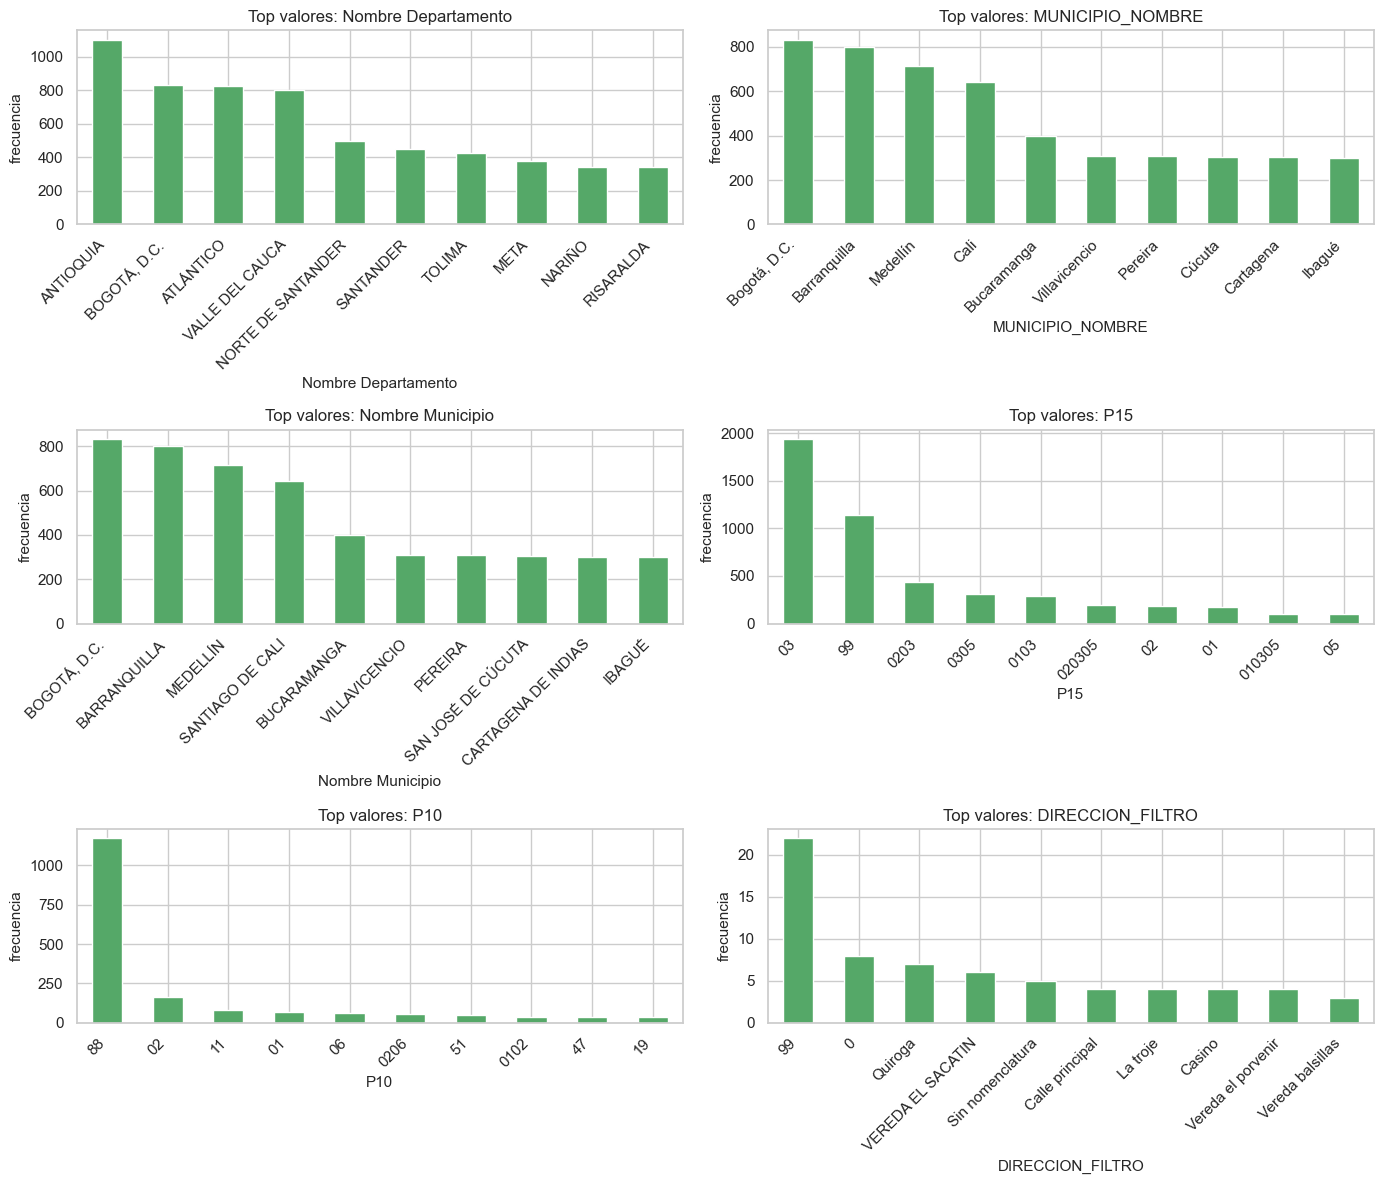

In [9]:
# Distribuciones categóricas
plot_categoricas(df_data, top_n_cols=6, top_n_vals=10)


In [10]:
# Detección simple de outliers por IQR
display(outliers_iqr(df_data))


,columna,outliers,%_outliers
13,P7,1582,20.65
21,P64,1537,20.06
16,P29,1416,18.48
18,P34,1192,15.56
14,P9,1175,15.34
15,P27,1057,13.80
3,SECTOR,951,12.41
17,P33,876,11.43
7,PB1,856,11.17
27,POBLACIÓN_ICFES,833,10.87


In [12]:
pd.set_option('display.max_columns', None)
df_data

,AÑO,GPSLAT,GPSLONG,SECTOR,SECCION,MANZANA,DIRECCION_FILTRO,DANE5,PB1,PERSONAS,EDAD,REDAD,GENERO,ESTRATO,P7,P9,P10,P15,P27,P29,P33,P34,P56,P57,P64,NIVEL_PIRAMIDE,POBLACION_5_16,Estudiantes_5_16,PROP_EDUC_5_16_MEN,HOGARES_INTERNET,POBLACIÓN_ICFES,TASA_INTERNET_ICFES,MUNICIPIO_NOMBRE,Nombre Municipio,Nombre Departamento
0,2018,10.952493,-74.777018,2201,8,3,Kr 14 # 21 105,8001,1,1,69,7,2,2,9,9.0,88,99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,233015,235368,1.010098,11425,16359,0.698392,Barranquilla,BARRANQUILLA,ATLÁNTICO
1,2018,NaN,NaN,203,1,13,kra 46A # 110_64,5001,1,5,56,6,2,2,1,NaN,88,99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,384358,372366,0.968800,21663,26759,0.809559,Medellín,MEDELLÍN,ANTIOQUIA
2,2018,NaN,NaN,203,1,13,Kra 46A # 110_60,5001,1,4,64,6,2,2,1,NaN,88,99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,384358,372366,0.968800,21663,26759,0.809559,Medellín,MEDELLÍN,ANTIOQUIA
3,2018,6.299582,-75.550590,203,2,2,kra 109 201 _28,5001,1,2,38,4,1,2,2,2.0,01,02,1.0,2.0,1.0,1.0,9.0,NaN,9.0,1,384358,372366,0.968800,21663,26759,0.809559,Medellín,MEDELLÍN,ANTIOQUIA
4,2018,7.090175,-73.145032,798,2,25,Cll 58 47 aw 8,68001,1,4,43,4,1,2,1234,234.0,0102035106071112131549182023,010304,1.0,1.0,2.0,1.0,9.0,NaN,8.0,2,94655,95781,1.011896,5355,6446,0.830748,Bucaramanga,BUCARAMANGA,SANTANDER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7657,2023,4.843900,74.066290,1,3,19,Calle14 13 80,25175,1,5,69,7,1,4,2,2.0,010624253043,0304,1.0,1.0,1.0,1.0,9.0,NaN,2.0,2,24997,27437,1.097612,1715,1839,0.932572,Chía,CHÍA,CUNDINAMARCA
7658,2023,NaN,NaN,1,2,7,Cl 6 a 3 99,25175,1,4,24,2,1,2,12,12.0,112123485741,01030508,1.0,1.0,1.0,1.0,5.0,NaN,2.0,1,24997,27437,1.097612,1715,1839,0.932572,Chía,CHÍA,CUNDINAMARCA
7659,2023,4.857498,74.055293,1,7,5,Calle 10 4 48 capincito,25175,1,5,47,5,1,2,231,123.0,01025106071112131415491820232529323335363743,0305,1.0,2.0,1.0,1.0,7.0,NaN,9.0,3,24997,27437,1.097612,1715,1839,0.932572,Chía,CHÍA,CUNDINAMARCA
7660,2023,4.853827,74.056633,2,6,35,Cea 3 6 20,25175,1,3,58,6,2,2,12,12.0,01020351060711,0203,1.0,1.0,4.0,1.0,9.0,NaN,9.0,1,24997,27437,1.097612,1715,1839,0.932572,Chía,CHÍA,CUNDINAMARCA


## Siguientes pasos sugeridos
- Revisar columnas con alto % de nulos y decidir imputación/eliminación.
- Explorar relaciones clave (pares de variables relevantes).
- Validar tipos (fechas, IDs) y posibles errores de captura.
- Generar features derivadas si avanzas a modelado.

## Tratamiento de datos 

se crean variables dummies de la pregunta P7

In [37]:
df_data['P7'].unique()

array([   9,    1,    2, 1234,   12,  123,    3,   21,   31,  124,   13,
         14,   32,  134,  132,   23,  431,  213,  321, 1324,    4,  231,
       1243,   43, 3241,  341,  241,  312, 1432, 3412,   24, 2341, 2134,
         41,  324, 3124,  423, 3421, 1342,  314,  142,  421, 4123, 3214,
        432,   88, 3142,   42,  412,  143,  214,  342, 4231, 1423])

Función para manejar las categorías

In [38]:
def create_dummies_with_nan_handling(df, column_name, special_cases=None):
    """
    Crea columnas binarias (dummies) para cada número individual único en una columna,
    manejando casos especiales y dejando NaN en las nuevas columnas si el valor original es NaN.
    
    Args:
        df (pd.DataFrame): DataFrame original.
        column_name (str): Nombre de la columna a procesar.
        special_cases (list): Lista de valores que deben tratarse como casos completos (e.g., '88').
    
    Returns:
        pd.DataFrame: DataFrame con las columnas dummies agregadas.
    """
    if special_cases is None:
        special_cases = []
    
    # Crear un conjunto para almacenar cada número individual y los casos especiales
    all_numbers = set(special_cases)

    # Recorrer los valores únicos de la columna
    unique_values = df[column_name].dropna().astype(str).unique()

    for value in unique_values:
        if value in special_cases:
            all_numbers.add(value)  # Mantener el caso especial completo
        else:
            for char in value:
                if char.isdigit():  # Solo considerar caracteres numéricos individuales
                    all_numbers.add(char)

    # Convertir el conjunto en una lista ordenada
    all_numbers = sorted(all_numbers, key=lambda x: int(x))

    # Crear columnas dummies para cada número individual y casos especiales
    for number in all_numbers:
        dummy_name = f"{column_name}_{number}"
        df[dummy_name] = df[column_name].apply(
            lambda x: np.nan if pd.isna(x) else int(number in str(x))
        )
    df = df.drop(columns=[column_name])
    return df


Se crean las variables dummies

In [39]:
df_data_1 = create_dummies_with_nan_handling(df_data, "P7", special_cases=["9", "88"])
df_data_1['Servicios_Telecomunicaciones_No'] = df_data_1['P7_9']|df_data_1['P7_88']
df_data_1['Servicios_Telecomunicaciones_Si'] = df_data_1['P7_1']|df_data_1['P7_2']|df_data_1['P7_3']|df_data_1['P7_4']
df_data_1 = df_data_1.drop(['P7_9','P7_88','P7_1','P7_2','P7_3','P7_4'],axis=1)
df_data_1

,AÑO,GPSLAT,GPSLONG,SECTOR,SECCION,MANZANA,DIRECCION_FILTRO,DANE5,PB1,PERSONAS,EDAD,REDAD,GENERO,ESTRATO,P9,P10,P15,P27,P29,P33,P34,P56,P57,P64,NIVEL_PIRAMIDE,POBLACION_5_16,Estudiantes_5_16,PROP_EDUC_5_16_MEN,HOGARES_INTERNET,POBLACIÓN_ICFES,TASA_INTERNET_ICFES,MUNICIPIO_NOMBRE,Nombre Municipio,Nombre Departamento,Servicios_Telecomunicaciones_No,Servicios_Telecomunicaciones_Si
0,2018,10.952493,-74.777018,2201,8,3,Kr 14 # 21 105,8001,1,1,69,7,2,2,9.0,88,99,nan,NaN,NaN,NaN,NaN,NaN,NaN,0,233015,235368,1.010098,11425,16359,0.698392,Barranquilla,BARRANQUILLA,ATLÁNTICO,1,0
1,2018,NaN,NaN,203,1,13,kra 46A # 110_64,5001,1,5,56,6,2,2,NaN,88,99,nan,NaN,NaN,NaN,NaN,NaN,NaN,0,384358,372366,0.968800,21663,26759,0.809559,Medellín,MEDELLÍN,ANTIOQUIA,0,1
2,2018,NaN,NaN,203,1,13,Kra 46A # 110_60,5001,1,4,64,6,2,2,NaN,88,99,nan,NaN,NaN,NaN,NaN,NaN,NaN,0,384358,372366,0.968800,21663,26759,0.809559,Medellín,MEDELLÍN,ANTIOQUIA,0,1
3,2018,6.299582,-75.550590,203,2,2,kra 109 201 _28,5001,1,2,38,4,1,2,2.0,01,02,1,2.0,1.0,1.0,9.0,NaN,9.0,1,384358,372366,0.968800,21663,26759,0.809559,Medellín,MEDELLÍN,ANTIOQUIA,0,1
4,2018,7.090175,-73.145032,798,2,25,Cll 58 47 aw 8,68001,1,4,43,4,1,2,234.0,0102035106071112131549182023,010304,1,1.0,2.0,1.0,9.0,NaN,8.0,2,94655,95781,1.011896,5355,6446,0.830748,Bucaramanga,BUCARAMANGA,SANTANDER,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7657,2023,4.843900,74.066290,1,3,19,Calle14 13 80,25175,1,5,69,7,1,4,2.0,010624253043,0304,1,1.0,1.0,1.0,9.0,NaN,2.0,2,24997,27437,1.097612,1715,1839,0.932572,Chía,CHÍA,CUNDINAMARCA,0,1
7658,2023,NaN,NaN,1,2,7,Cl 6 a 3 99,25175,1,4,24,2,1,2,12.0,112123485741,01030508,1,1.0,1.0,1.0,5.0,NaN,2.0,1,24997,27437,1.097612,1715,1839,0.932572,Chía,CHÍA,CUNDINAMARCA,0,1
7659,2023,4.857498,74.055293,1,7,5,Calle 10 4 48 capincito,25175,1,5,47,5,1,2,123.0,01025106071112131415491820232529323335363743,0305,1,2.0,1.0,1.0,7.0,NaN,9.0,3,24997,27437,1.097612,1715,1839,0.932572,Chía,CHÍA,CUNDINAMARCA,0,1
7660,2023,4.853827,74.056633,2,6,35,Cea 3 6 20,25175,1,3,58,6,2,2,12.0,01020351060711,0203,1,1.0,4.0,1.0,9.0,NaN,9.0,1,24997,27437,1.097612,1715,1839,0.932572,Chía,CHÍA,CUNDINAMARCA,0,1


Se crea las variables dummies de la pregunta P15

In [40]:
df_data['P15'].unique()

array(['99', '02', '010304', '03', '0203', '060701', '0103', '01030405',
       '0204030810', '01', '0103050608', '06', '0102', '01030405060708',
       '04', '0305', '0403', '0304', '020409', '0408', '020403', '010203',
       '01080903', '0102030406', '010307', '010203040809', '020305',
       '020306', '0203040708', '020304', '0205', '01030406', '030608',
       '05', '040203', '01020304050608', '010204', '0405', '010306',
       '0204', '010203040608', '0103050607', '0603', '0307', '02030406',
       '0102031005', '020305040610', '010305', '01020305', '0102030405',
       '020308', '010203040607', '01030507', '010203050608',
       '0204030506071011', '01020306', '050403', '030405', '0302',
       '01030508', '01020405', '0206', '010402', '0205060308', '030406',
       '0102030507080910', '010406', '0104', '0301020405', '0306',
       '060304', '0203050607', '02030508', '010205', '02030504',
       '02030405', '02030409', '02030405080910', '0501', '050103',
       '030206', '0301',

In [41]:
df_data_1['Dispositivos_hogar_No'] = df_data_1['P15']=="99"
df_data_1= df_data_1.drop(['P15'], axis=1)
df_data_1

,AÑO,GPSLAT,GPSLONG,SECTOR,SECCION,MANZANA,DIRECCION_FILTRO,DANE5,PB1,PERSONAS,EDAD,REDAD,GENERO,ESTRATO,P9,P10,P27,P29,P33,P34,P56,P57,P64,NIVEL_PIRAMIDE,POBLACION_5_16,Estudiantes_5_16,PROP_EDUC_5_16_MEN,HOGARES_INTERNET,POBLACIÓN_ICFES,TASA_INTERNET_ICFES,MUNICIPIO_NOMBRE,Nombre Municipio,Nombre Departamento,Servicios_Telecomunicaciones_No,Servicios_Telecomunicaciones_Si,Dispositivos_hogar_No
0,2018,10.952493,-74.777018,2201,8,3,Kr 14 # 21 105,8001,1,1,69,7,2,2,9.0,88,nan,NaN,NaN,NaN,NaN,NaN,NaN,0,233015,235368,1.010098,11425,16359,0.698392,Barranquilla,BARRANQUILLA,ATLÁNTICO,1,0,True
1,2018,NaN,NaN,203,1,13,kra 46A # 110_64,5001,1,5,56,6,2,2,NaN,88,nan,NaN,NaN,NaN,NaN,NaN,NaN,0,384358,372366,0.968800,21663,26759,0.809559,Medellín,MEDELLÍN,ANTIOQUIA,0,1,True
2,2018,NaN,NaN,203,1,13,Kra 46A # 110_60,5001,1,4,64,6,2,2,NaN,88,nan,NaN,NaN,NaN,NaN,NaN,NaN,0,384358,372366,0.968800,21663,26759,0.809559,Medellín,MEDELLÍN,ANTIOQUIA,0,1,True
3,2018,6.299582,-75.550590,203,2,2,kra 109 201 _28,5001,1,2,38,4,1,2,2.0,01,1,2.0,1.0,1.0,9.0,NaN,9.0,1,384358,372366,0.968800,21663,26759,0.809559,Medellín,MEDELLÍN,ANTIOQUIA,0,1,False
4,2018,7.090175,-73.145032,798,2,25,Cll 58 47 aw 8,68001,1,4,43,4,1,2,234.0,0102035106071112131549182023,1,1.0,2.0,1.0,9.0,NaN,8.0,2,94655,95781,1.011896,5355,6446,0.830748,Bucaramanga,BUCARAMANGA,SANTANDER,0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7657,2023,4.843900,74.066290,1,3,19,Calle14 13 80,25175,1,5,69,7,1,4,2.0,010624253043,1,1.0,1.0,1.0,9.0,NaN,2.0,2,24997,27437,1.097612,1715,1839,0.932572,Chía,CHÍA,CUNDINAMARCA,0,1,False
7658,2023,NaN,NaN,1,2,7,Cl 6 a 3 99,25175,1,4,24,2,1,2,12.0,112123485741,1,1.0,1.0,1.0,5.0,NaN,2.0,1,24997,27437,1.097612,1715,1839,0.932572,Chía,CHÍA,CUNDINAMARCA,0,1,False
7659,2023,4.857498,74.055293,1,7,5,Calle 10 4 48 capincito,25175,1,5,47,5,1,2,123.0,01025106071112131415491820232529323335363743,1,2.0,1.0,1.0,7.0,NaN,9.0,3,24997,27437,1.097612,1715,1839,0.932572,Chía,CHÍA,CUNDINAMARCA,0,1,False
7660,2023,4.853827,74.056633,2,6,35,Cea 3 6 20,25175,1,3,58,6,2,2,12.0,01020351060711,1,1.0,4.0,1.0,9.0,NaN,9.0,1,24997,27437,1.097612,1715,1839,0.932572,Chía,CHÍA,CUNDINAMARCA,0,1,False


Se crea variables dummies para la pregunta P27

In [42]:
df_data_1['P27']=df_data['P27'].astype(str).apply(lambda x: x.strip(".0"))
df_data_1['P27'].unique()


array(['nan', '1', '3', '9', '2', '88', '99', '77', '12', '21', '7'],
      dtype=object)

In [43]:
def create_dummies (x):
    if "1" in x or "2" in x or "3" in x:
        return True
    else: 
        return False
    
df_data_1["conexion_hogar_si"]=df_data_1["P27"].apply(create_dummies)
df_data_1 = df_data_1.drop(["P27"], axis=1)
df_data_1

,AÑO,GPSLAT,GPSLONG,SECTOR,SECCION,MANZANA,DIRECCION_FILTRO,DANE5,PB1,PERSONAS,EDAD,REDAD,GENERO,ESTRATO,P9,P10,P29,P33,P34,P56,P57,P64,NIVEL_PIRAMIDE,POBLACION_5_16,Estudiantes_5_16,PROP_EDUC_5_16_MEN,HOGARES_INTERNET,POBLACIÓN_ICFES,TASA_INTERNET_ICFES,MUNICIPIO_NOMBRE,Nombre Municipio,Nombre Departamento,Servicios_Telecomunicaciones_No,Servicios_Telecomunicaciones_Si,Dispositivos_hogar_No,conexion_hogar_si
0,2018,10.952493,-74.777018,2201,8,3,Kr 14 # 21 105,8001,1,1,69,7,2,2,9.0,88,NaN,NaN,NaN,NaN,NaN,NaN,0,233015,235368,1.010098,11425,16359,0.698392,Barranquilla,BARRANQUILLA,ATLÁNTICO,1,0,True,False
1,2018,NaN,NaN,203,1,13,kra 46A # 110_64,5001,1,5,56,6,2,2,NaN,88,NaN,NaN,NaN,NaN,NaN,NaN,0,384358,372366,0.968800,21663,26759,0.809559,Medellín,MEDELLÍN,ANTIOQUIA,0,1,True,False
2,2018,NaN,NaN,203,1,13,Kra 46A # 110_60,5001,1,4,64,6,2,2,NaN,88,NaN,NaN,NaN,NaN,NaN,NaN,0,384358,372366,0.968800,21663,26759,0.809559,Medellín,MEDELLÍN,ANTIOQUIA,0,1,True,False
3,2018,6.299582,-75.550590,203,2,2,kra 109 201 _28,5001,1,2,38,4,1,2,2.0,01,2.0,1.0,1.0,9.0,NaN,9.0,1,384358,372366,0.968800,21663,26759,0.809559,Medellín,MEDELLÍN,ANTIOQUIA,0,1,False,True
4,2018,7.090175,-73.145032,798,2,25,Cll 58 47 aw 8,68001,1,4,43,4,1,2,234.0,0102035106071112131549182023,1.0,2.0,1.0,9.0,NaN,8.0,2,94655,95781,1.011896,5355,6446,0.830748,Bucaramanga,BUCARAMANGA,SANTANDER,0,1,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7657,2023,4.843900,74.066290,1,3,19,Calle14 13 80,25175,1,5,69,7,1,4,2.0,010624253043,1.0,1.0,1.0,9.0,NaN,2.0,2,24997,27437,1.097612,1715,1839,0.932572,Chía,CHÍA,CUNDINAMARCA,0,1,False,True
7658,2023,NaN,NaN,1,2,7,Cl 6 a 3 99,25175,1,4,24,2,1,2,12.0,112123485741,1.0,1.0,1.0,5.0,NaN,2.0,1,24997,27437,1.097612,1715,1839,0.932572,Chía,CHÍA,CUNDINAMARCA,0,1,False,True
7659,2023,4.857498,74.055293,1,7,5,Calle 10 4 48 capincito,25175,1,5,47,5,1,2,123.0,01025106071112131415491820232529323335363743,2.0,1.0,1.0,7.0,NaN,9.0,3,24997,27437,1.097612,1715,1839,0.932572,Chía,CHÍA,CUNDINAMARCA,0,1,False,True
7660,2023,4.853827,74.056633,2,6,35,Cea 3 6 20,25175,1,3,58,6,2,2,12.0,01020351060711,1.0,4.0,1.0,9.0,NaN,9.0,1,24997,27437,1.097612,1715,1839,0.932572,Chía,CHÍA,CUNDINAMARCA,0,1,False,True


crear variables dummies para pregunta P29

In [44]:
df_data_1['P29']=df_data['P29'].astype(str).apply(lambda x: x.strip(".0"))

In [45]:
def create_dummies_P29 (x):
    if "1" in x:
        return True
    else: 
        return False
    
df_data_1["interrupciones_si"]=df_data_1["P29"].apply(create_dummies_P29)
df_data_1 = df_data_1.drop(["P29"], axis=1)
df_data_1

,AÑO,GPSLAT,GPSLONG,SECTOR,SECCION,MANZANA,DIRECCION_FILTRO,DANE5,PB1,PERSONAS,EDAD,REDAD,GENERO,ESTRATO,P9,P10,P33,P34,P56,P57,P64,NIVEL_PIRAMIDE,POBLACION_5_16,Estudiantes_5_16,PROP_EDUC_5_16_MEN,HOGARES_INTERNET,POBLACIÓN_ICFES,TASA_INTERNET_ICFES,MUNICIPIO_NOMBRE,Nombre Municipio,Nombre Departamento,Servicios_Telecomunicaciones_No,Servicios_Telecomunicaciones_Si,Dispositivos_hogar_No,conexion_hogar_si,interrupciones_si
0,2018,10.952493,-74.777018,2201,8,3,Kr 14 # 21 105,8001,1,1,69,7,2,2,9.0,88,NaN,NaN,NaN,NaN,NaN,0,233015,235368,1.010098,11425,16359,0.698392,Barranquilla,BARRANQUILLA,ATLÁNTICO,1,0,True,False,False
1,2018,NaN,NaN,203,1,13,kra 46A # 110_64,5001,1,5,56,6,2,2,NaN,88,NaN,NaN,NaN,NaN,NaN,0,384358,372366,0.968800,21663,26759,0.809559,Medellín,MEDELLÍN,ANTIOQUIA,0,1,True,False,False
2,2018,NaN,NaN,203,1,13,Kra 46A # 110_60,5001,1,4,64,6,2,2,NaN,88,NaN,NaN,NaN,NaN,NaN,0,384358,372366,0.968800,21663,26759,0.809559,Medellín,MEDELLÍN,ANTIOQUIA,0,1,True,False,False
3,2018,6.299582,-75.550590,203,2,2,kra 109 201 _28,5001,1,2,38,4,1,2,2.0,01,1.0,1.0,9.0,NaN,9.0,1,384358,372366,0.968800,21663,26759,0.809559,Medellín,MEDELLÍN,ANTIOQUIA,0,1,False,True,False
4,2018,7.090175,-73.145032,798,2,25,Cll 58 47 aw 8,68001,1,4,43,4,1,2,234.0,0102035106071112131549182023,2.0,1.0,9.0,NaN,8.0,2,94655,95781,1.011896,5355,6446,0.830748,Bucaramanga,BUCARAMANGA,SANTANDER,0,1,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7657,2023,4.843900,74.066290,1,3,19,Calle14 13 80,25175,1,5,69,7,1,4,2.0,010624253043,1.0,1.0,9.0,NaN,2.0,2,24997,27437,1.097612,1715,1839,0.932572,Chía,CHÍA,CUNDINAMARCA,0,1,False,True,True
7658,2023,NaN,NaN,1,2,7,Cl 6 a 3 99,25175,1,4,24,2,1,2,12.0,112123485741,1.0,1.0,5.0,NaN,2.0,1,24997,27437,1.097612,1715,1839,0.932572,Chía,CHÍA,CUNDINAMARCA,0,1,False,True,True
7659,2023,4.857498,74.055293,1,7,5,Calle 10 4 48 capincito,25175,1,5,47,5,1,2,123.0,01025106071112131415491820232529323335363743,1.0,1.0,7.0,NaN,9.0,3,24997,27437,1.097612,1715,1839,0.932572,Chía,CHÍA,CUNDINAMARCA,0,1,False,True,False
7660,2023,4.853827,74.056633,2,6,35,Cea 3 6 20,25175,1,3,58,6,2,2,12.0,01020351060711,4.0,1.0,9.0,NaN,9.0,1,24997,27437,1.097612,1715,1839,0.932572,Chía,CHÍA,CUNDINAMARCA,0,1,False,True,True
